In [139]:
import pandas as pd, numpy as np, os, math, sklearn.metrics as skm, seaborn as sns, pickle
from matplotlib import pyplot as plt

# This cell can be used to calculate statistics
# related to object detection and classification

# add some basic info necessary for calculations

with open('./useful_dicts/file_to_nearest_neighbor.pkl', 'rb') as f:
    file_to_nn = pickle.load(f)

with open('./useful_dicts/file_to_scaling.pkl', 'rb') as f:
    file_to_scaling = pickle.load(f)

def add_info(df, path_obj):
    if os.path.isfile(f'./230505_noise_results/rich_data/{path_obj.name[:-4]}_corrected.csv'):
        return pd.read_csv(f'./230505_noise_results/rich_data/{path_obj.name[:-4]}_corrected.csv')
    
    def IoU(df):
        right_i = df[['rgt', 'rpd']].min(axis=1)
        left_i = df[['lgt', 'lpd']].max(axis=1)

        right_u = df[['rgt', 'rpd']].max(axis=1)
        left_u = df[['lgt', 'lpd']].min(axis=1)
        IoU = (right_i - left_i)/(right_u - left_u)
        return IoU

    # Add in left to right rank for correlation with scalled
    # results data with original data
    df['rank'] = (df['file'] != df['file'].shift()).cumsum() - 1
    df['rank'] = df.groupby('file')['rank'].cumcount()

    # Extract predicted class
    df['pcls'] = df.iloc[:, 8:17].idxmax(axis=1)
    # Counts as a match if predicted class matches true and the data contains a GT Box and Pred Box
    df['cls'].fillna('phi', inplace=True)
    df['match'] = (df['pcls'] == df['cls'])
    
    # We are swapping out the term 'bg' for 'phi' AFTER matches picked
    bg_mask = df['pcls'] == 'bg'
    df.loc[bg_mask, 'pcls'] = 'phi'

    # Calculate IoUs
    IoU_mask = (df['gt'] == 1) & (df['pcls'] != 'phi')
    df.loc[IoU_mask, 'IoU'] = IoU(df)

    df.to_csv(f'./230505_noise_results/rich_data/{path_obj.name[:-4]}_corrected.csv', index=False)
    return df

# calculate diffusion matrix
def confusion_matrix(df):
    # confusion matrix generated only on data with aligning GT and PD boxes
    mechs = ['E','ECb','ECa','ECE','DISP','SR','T','ECP', 'phi']
    cm = skm.confusion_matrix(df['cls'], df['pcls'], labels=mechs, normalize='true') # normalize='true'
    return cm, mechs

def plot_conf_mat(df, cm, labels, title):
    plt.subplots(figsize=(8,5))
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='viridis')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    cur = df.loc[~((df['cls'] == 'phi') & (df['pcls'] == 'phi'))]
    tp = len(cur.loc[(cur['match']) & (cur['cls'] != 'phi')])
    fn = len(cur.loc[(cur['gt'] == 0) & (cur['pd'] == 0)])
    fp1 = len(cur.loc[(cur['gt'] == 0) & (cur['pd'] == 1) & (cur['pcls'] != 'bg')])
    fp2 = len(cur.loc[(cur['gt'] == 1) & (cur['pd'] == 1) & (cur['match'] == False)])
    accuracy = tp / (fn + fp1 + fp2 + tp)
    plt.title(round(accuracy, 4))
    plt.savefig(title, dpi=200)
    #plt.show()

# calculates stats related to object detection results
def obj_det_stats(df, save=False, path=None, train_noise=0, test_noise=0, scan_rates=6):
    stats = {}
    stats['predicted_pos'] = len(df.loc[df['pd'] == 1]) # TP, FP
    stats['population'] = len(df.loc[df['gt'] == 1]) # total GT bounds
    stats['false_neg'] = len(df.loc[(df['gt'] == 1) & (df['pd'] == 0)]) # FN
    stats['false_pos'] = len(df.loc[(df['gt'] == 0) & (df['pd'] == 1)])
    stats['true_pos'] = len(df.loc[(df['gt'] == 1) & (df['pd'] == 1)]) # TP

    # Object Detection Stats
    stats['precision'] = stats['true_pos'] / stats['predicted_pos']
    stats['recall'] = stats['true_pos'] / stats['population']
    stats['f1'] = 2*(stats['precision']*stats['recall'])/(stats['precision'] + stats['recall'])

    if save:
        od_df = pd.DataFrame(stats.values(), index=stats.keys(), columns=[f'{train_noise}_{test_noise}'])
        od_df.to_csv(f'{path}/Object_Detection_Stats_{train_noise}_{test_noise}_{scan_rates}.csv', index=True)
    return stats

# calculates stats related to classification results 
def class_stats(df, save=False, path=None, train_noise=0, test_noise=0, scan_rates=6):
    stats = {}
    stats['predicted_pos'] = len(df.loc[df['pd'] == 1]) # TP, FP
    stats['population'] = len(df.loc[df['gt'] == 1]) # total GT bounds
    stats['false_neg'] = len(df.loc[(df['gt'] == 1) & (df['pd'] == 0)]) # FN
    stats['false_pos'] = len(df.loc[(df['pd'] == 1) & (df['match'] == False)])
    stats['true_pos'] = len(df.loc[df['match']]) # Classification corrected TP

    # Classification Stats
    stats['overall_precision'] = stats['true_pos'] / stats['predicted_pos']
    stats['overall_recall'] = stats['true_pos'] / stats['population']
    stats['overall_f1'] = 2*(stats['overall_precision']*stats['overall_recall'])/(stats['overall_precision'] + stats['overall_recall'])

    # Keeping here to make sure it differs from precision
    stats['stats_accuracy'] = stats['true_pos']/(stats['predicted_pos'] + stats['false_neg'])

    # IoU
    stats['Average_IoU'] = np.mean(df.loc[df['match']].IoU)

    # Mech by mech things
    mechs = ['E','ECb','ECa','ECE','DISP','SR','T','ECP']
    prec_numerator = 0
    prec_denominator = 0
    rec_numerator = 0
    rec_denominator = 0
    for mech in mechs:
        # Calculate IoU
        f = df.loc[(df['cls'] == mech) & (df['match'])].copy()
        stats[f'IoU_{mech}'] = np.mean(f['IoU'])

        if len(f) == 0:
            stats[f'prec_{mech}'] = 0
            stats[f'rec_{mech}'] = 0
            stats[f'F1_{mech}'] = 0

        else:
            # Calculate class precisions
            f = df.loc[df['pcls'] == mech]
            hits = len(f.loc[f['cls'] == mech])
            stats[f'prec_{mech}'] = hits/len(f)
            prec_numerator += hits
            prec_denominator += len(f)

            # Calculate class recalls
            f = df.loc[df['cls'] == mech]
            hits = len(f.loc[f['pcls'] == mech])
            stats[f'rec_{mech}'] = hits/len(f) 
            rec_numerator += hits
            rec_denominator += len(f)
            
            # Calculate class f1
            if stats[f'prec_{mech}']+stats[f'rec_{mech}'] == 0:
                stats[f'F1_{mech}'] = 0
            else:
                stats[f'F1_{mech}'] = 2*(stats[f'prec_{mech}']*stats[f'rec_{mech}'])/(stats[f'prec_{mech}']+stats[f'rec_{mech}'])

    # these are to double check that overall prec and rec align
    stats['overall_prec_2'] = prec_numerator/prec_denominator
    stats['overall_rec_2'] = rec_numerator/rec_denominator

    if save:
        cls_df = pd.DataFrame(stats.values(), index=stats.keys(), columns=[f'{train_noise}_{test_noise}'])
        cls_df.to_csv(f'{path}/Overall_Stats_{train_noise}_{test_noise}_{scan_rates}.csv', index=True)

    return stats

# adds info from og metadata files to results
def add_og_info(df):
    df['key'] = df.apply(lambda x : x['file'].split('/')[-1][:-4] + str(x['rank']), axis=1)
    df['scaling'] = df['key'].map(file_to_scaling.get)
    df['closest_redox'] = df['key'].map(file_to_nn.get)
    df.drop('key', axis=1, inplace=True)
    return df

for path_obj in os.scandir('./230505_noise_results/data'):
    file_path = path_obj.path
    file_name = path_obj.name
    print(file_name)
    details = file_name.split('_')
    train_noise = details[2]
    test_noise = details[3][:-4]
    full_data = pd.read_csv(file_path)
    full_data = add_info(full_data, path_obj)
    
    # calculate object detection related information
    od_stats = obj_det_stats(full_data, save=True, path='./230505_noise_results/noise_stats', train_noise=train_noise, test_noise=test_noise)
    notdetected = full_data.loc[(full_data['gt'] == 1) & (full_data['pd'] == 0)].copy()
    notdetected.reset_index(drop=True, inplace=True)
    notdetected = add_og_info(notdetected)
    notdetected.to_csv(f'./230505_noise_results/noise_errs/notdetected_{train_noise}_{test_noise}_6.csv', index=False)

    # calculate overall (OD + classification) related information
    full_data = full_data.loc[~((full_data['gt'] == 1) & (full_data['pcls'] == 'phi'))]
    cls_stats = class_stats(full_data, save=True, path='./230505_noise_results/noise_stats', train_noise=train_noise, test_noise=test_noise)
    misclasses = full_data.loc[(full_data['gt'] == 1) & (full_data['pd'] == 1) & (full_data['pcls'] != full_data['cls'])].copy()
    misclasses = misclasses.loc[misclasses['pcls'] != 'phi']
    misclasses.reset_index(drop=True, inplace=True)
    misclasses = add_og_info(misclasses)
    misclasses.to_csv(f'./230505_noise_results/noise_errs/misclasses_{train_noise}_{test_noise}_6.csv', index=False)
    
    print(file_name + ': completed')

result_noise_0.01_0.05.csv
result_noise_0.01_0.05.csv: completed
result_noise_0.0_0.2.csv
result_noise_0.0_0.2.csv: completed
result_noise_0.05_1.0.csv
result_noise_0.05_1.0.csv: completed
result_noise_0.2_0.05.csv
result_noise_0.2_0.05.csv: completed
result_noise_0.1_0.5.csv
result_noise_0.1_0.5.csv: completed
result_noise_0.0_0.0.csv
result_noise_0.0_0.0.csv: completed
result_noise_0.0_0.1.csv
result_noise_0.0_0.1.csv: completed
result_noise_0.1_0.0.csv
result_noise_0.1_0.0.csv: completed
result_noise_0.2_1.0.csv
result_noise_0.2_1.0.csv: completed
result_noise_0.01_0.02.csv
result_noise_0.01_0.02.csv: completed
result_noise_0.0_0.5.csv
result_noise_0.0_0.5.csv: completed
result_noise_0.1_0.1.csv
result_noise_0.1_0.1.csv: completed
result_noise_0.2_0.01.csv
result_noise_0.2_0.01.csv: completed
result_noise_0.01_0.01.csv
result_noise_0.01_0.01.csv: completed
result_noise_0.2_0.02.csv
result_noise_0.2_0.02.csv: completed
result_noise_0.1_0.2.csv
result_noise_0.1_0.2.csv: completed
resu

In [132]:
import os, pandas as pd, pickle

# Used for general meta data calculations on OG data

path = '/Volumes/LaCie/20230310/Reports'
file_to_neighbor = {}
file_to_scaling = {}
for obj in os.scandir(path):
   if not obj.name.startswith('info'):
      continue
   df = pd.read_csv(obj.path)
   df['rank'] = (df['File'] != df['File'].shift()).cumsum() - 1
   df['rank'] = df.groupby('File')['rank'].cumcount()

   # num events (0)    
   value_counts = df['File'].value_counts()  
   count_column = df['File'].map(value_counts.get)
   df['eventcount'] = count_column 

   # has left neighbor (1)
   df['hasleft'] = False
   left_mask = df['rank'] > 0
   df.loc[left_mask, 'hasleft'] = True

   # has right neighbor (2)
   df['hasright'] = False
   right_mask = df['rank'] < df['eventcount']-1
   df.loc[right_mask, 'hasright'] = True

   # calculate nearest left (3)
   df['leftneighbor'] = float('inf')
   df.loc[left_mask, 'leftneighbor'] = df['Merge_Left'] - df['Merge_Right'].shift(1)

   # calculate nearest right (4)
   df['rightneighbor'] = float('inf')
   df.loc[right_mask, 'rightneighbor'] = df['Merge_Left'].shift(-1) - df['Merge_Right']

   # calc global min (5)
   df['closest_redox'] = df[['leftneighbor', 'rightneighbor']].min(axis=1)
   # drop (0-4)
   df['key'] = df.apply(lambda x : x['File'] + str(x['rank']), axis=1)
   file_to_neighbor.update(df[['key', 'closest_redox']].set_index('key')['closest_redox'].to_dict())
   file_to_scaling.update(df[['key', 'Scaling']].set_index('key')['Scaling'].to_dict())

with open('file_to_nearest_neighbor.pkl', 'wb') as f:
   pickle.dump(file_to_neighbor, f)
with open('file_to_scaling.pkl', 'wb') as f:
   pickle.dump(file_to_scaling, f)

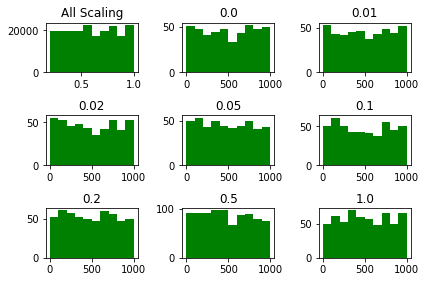

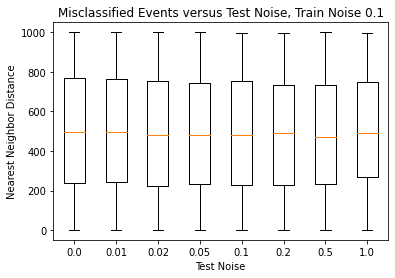

In [272]:
import os, pandas as pd
from matplotlib import pyplot as plt

# Box and whisker plots cell for evaluating impact of scaling and neighbor 
# distance on detection – also can plot all distributions separately

type = 'misclasses'
noise = 0.1
with open('all_closest_redox.pkl', 'rb') as cr:
   all_closest_redox = pickle.load(cr)
with open('all_scalings.pkl', 'rb') as sc:
   all_scalings = pickle.load(sc)
fig, axs = plt.subplots(3,3)
axs[0, 0].hist(all_scalings, bins=10, color='green')
axs[0,0].set_title('All Scaling') 

i = 1
datas = []
test_noises = [0.0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]
for test_noise in test_noises:
   misclasses = pd.read_csv(f'./230505_noise_results/noise_errs/{type}_{noise}_{test_noise}.csv')
   misclasses = misclasses.loc[misclasses['closest_redox'] < float('inf')]
   row = i // 3
   col = i % 3
   axs[row, col].hist(misclasses['closest_redox'], bins=10, color='green')
   axs[row, col].set_title(test_noise)
   i += 1
   datas.append(misclasses['closest_redox'])
fig.tight_layout(pad=1.0)
plt.show()
plt.clf()

plt.boxplot(datas, labels=test_noises)
plt.title(f'Misclassified Events versus Test Noise, Train Noise {noise}')
plt.ylabel('Nearest Neighbor Distance')
plt.xlabel('Test Noise')
plt.savefig(f'./summary_figs/boxplot_{type}_{noise}.png', dpi=200)
#plt.show()

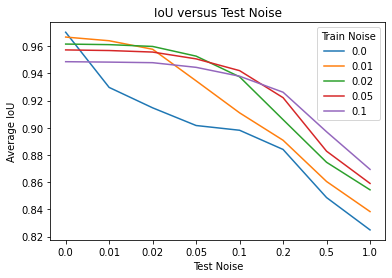

In [223]:
import os, pandas as pd
from matplotlib import pyplot as plt
from collections import defaultdict
# Figures to generate
# General themes
# 1. noise impact on FN, FP, F1
# 2. noise impact on the distributions for class err and misdetects


noise_dicts = defaultdict(list)
for path_obj in os.scandir('./230505_noise_results/noise_stats'):
    if not path_obj.name.startswith('Overall'):
        continue
    file_path = path_obj.path
    file_name = path_obj.name
    details = file_name.split('_')
    train_noise = details[2]
    test_noise = details[3][:-4]
    df = pd.read_csv(file_path, index_col=0)
    noise_dicts[train_noise].append((test_noise, df.loc['Average_IoU', df.columns[0]]))

# full_data_name = f'result_noise_{train_noise}_{test_noise}_corrected.csv'
# path = f'./230505_noise_results/rich_data/'

for train_noise in sorted(noise_dicts.keys()):
    details = noise_dicts[train_noise]
    details = sorted(details)
    test_noises = [d[0] for d in details]
    counts = [d[1] for d in details]
    # for test_noise, count in details:
    #     full_data_name = f'result_noise_{train_noise}_{test_noise}_corrected.csv'
    #     full_data = pd.read_csv(path + full_data_name)
    #     pop = len(full_data.loc[(full_data['pd'] == 1) & (full_data['gt'] == 1)])
    #     counts.append(count/pop)
    plt.plot(test_noises, counts, label=train_noise)
    
plt.legend(title='Train Noise')
plt.title('IoU versus Test Noise')
plt.ylabel('Average IoU')
plt.xlabel('Test Noise')
plt.savefig('./summary_figs/noise_vs_IoU_overall.png', dpi=150)

In [ ]:
# for path_obj in os.scandir('.'):
#     if not path_obj.name.endswith('csv'):
#         continue
#     file_path = path_obj.path
#     file_name = path_obj.name
#     details = file_name.split('_')
#     train_noise = details[2]
#     test_noise = details[3][:-4]
#     print(file_name)
#     if os.path.isfile(f'./230505_noise_results/noise_errs/notdetected_{train_noise}_{test_noise}.csv'):
#         continue
#     full_data = pd.read_csv(file_path)
#     full_data = add_info(full_data, path_obj)
#     od_stats = obj_det_stats(full_data)
#     cls_stats = class_stats(full_data, file_name)
#     od_df = pd.DataFrame(od_stats.values(), index=od_stats.keys(), columns=[f'{train_noise}_{test_noise}'])
#     od_df.to_csv(f'./230505_noise_results/noise_stats/Object_Detection_Stats_{train_noise}_{test_noise}.csv', index=True)
#     cls_df = pd.DataFrame(cls_stats.values(), index=cls_stats.keys(), columns=[f'{train_noise}_{test_noise}'])
#     cls_df.to_csv(f'./230505_noise_results/noise_stats/Overall_Stats_{train_noise}_{test_noise}.csv', index=True)
#     with open('file_to_meta.pkl', 'rb') as f:
#         file_to_meta = pickle.load(f) 
#     # note: background dropped from full_data at this point
#     misclasses = full_data.loc[(full_data['gt'] == 1) & (full_data['pd'] == 1) & (full_data['pcls'] != full_data['cls'])].copy()
#     misclasses.reset_index(drop=True, inplace=True)
#     notdetected = full_data.loc[(full_data['gt'] == 1) & (full_data['pd'] == 0)].copy()
#     notdetected.reset_index(drop=True, inplace=True)
#     misclasses = add_og_info(misclasses)
#     notdetected = add_og_info(notdetected)
#     notdetected.to_csv(f'./230505_noise_results/noise_errs/notdetected_{train_noise}_{test_noise}.csv', index=False)
#     misclasses.to_csv(f'./230505_noise_results/noise_errs/misclasses_{train_noise}_{test_noise}.csv', index=False)
#     print(file_name + ': completed')

# noise = 0.1
# big_df = pd.DataFrame()
# for obj in os.scandir('./230505_noise_results/rich_data'):
    # details = obj.name.split('_')
    # train_noise = details[2]
    # test_noise = details[3]
    # if float(train_noise) != noise or float(test_noise) > noise:
    #     continue
    # data = pd.read_csv(obj.path)
    # data.loc[data['gt'] == 0, 'cls'] = 'phi'
    # data.loc[data['pcls'] == 'FN', 'pcls'] = 'phi'
    # data['noise'] = test_noise
    # big_df = pd.concat([big_df, data])
# conf_mat, labels = confusion_matrix(big_df)
# plot_conf_mat(big_df, conf_mat, labels, f'{noise}_results_confmat.png')